# Description

The notebook contains checks that compare the prod system output vs that of the prod simulation run ensuring basic sanity.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms as oms

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8b54d7b2-cbba-40a6-a7ce-0c4980452cb5.json'
INFO  # Git
  branch_name='CmampTask5052_Add_notional_cost_summary_by_bar_to_notebooks'
  hash='468cd1a48'
  # Last commits:
    * 468cd1a48 paul     Checkpoint                                                        ( 5 minutes ago) Tue Aug 22 18:54:04 2023  (HEAD -> CmampTask5052_Add_notional_cost_summary_by_bar_to_notebooks, origin/CmampTask5052_Add_notional_cost_summary_by_bar_to_notebooks)
    * fabb8e16c Nina Lee fix_reconcile_multiday_invoke (#5071)                             (22 minutes ago) Tue Aug 22 18:37:28 2023           
    * 816f87740 DanilYachmenev CmTask4724: Unwrap historical simulation script (#5088)           (45 minutes ago) Tue Aug 22 18:14:50 2023           
# Machine info
  system=Linux
  node name=604020d06efe
  release=5.15.0-1033-aws
  version=#37~20.04.1-Ubuntu SMP Fri Mar 17 11:39:30 UTC 2023
  machine

# Build the reconciliation config

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
# in the system reconciliation flow.
config = cconfig.get_config_from_env()
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    dst_root_dir = "/shared_data/ecs/preprod/prod_reconciliation/"
    dag_builder_name = "C3a"
    start_timestamp_as_str = "20230802_154500"
    end_timestamp_as_str = "20230802_160000"
    run_mode = "prod"
    mode = "scheduled"
    config_list = oms.build_reconciliation_configs(
        dst_root_dir,
        dag_builder_name,
        start_timestamp_as_str,
        end_timestamp_as_str,
        run_mode,
        mode,
    )
    config = config_list[0]
print(config)

INFO  Using hardwired config
INFO  run_date='20230802'
INFO  Using run_date=20230802
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation/', dag_builder_name='C3a', run_mode='prod', start_timestamp_as_str='20230802_154500', end_timestamp_as_str='20230802_160000'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000'
INFO  system_log_dir='system_log_dir.scheduled'
meta: 
  date_str: 20230802
  asset_class: crypto
  run_tca: False
  bar_duration: 5T
system_log_path: 
  prod: /shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/prod/system_log_dir.scheduled
  sim: /shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/simulation/system_log_dir
system_config_func_as_str: dataflow_orange.system.Cx.get_Cx_system_config_template_instance('C3a')
research_forecast_evaluator_from_prices: 
  init: 
    price_col: vwap
    prediction_col: feature
    volatility_col: garman_

# Specify data to load

In [5]:
# The dict points to `system_log_dir` for different experiments.
system_log_path_dict = dict(config["system_log_path"].to_dict())

In [6]:
# This dict points to `system_log_dir/dag/node_io/node_io.data` for different experiments.
data_type = "dag_data"
dag_path_dict = oms.get_system_log_paths(system_log_path_dict, data_type)
dag_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/prod/system_log_dir.scheduled/dag/node_io/node_io.data',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/simulation/system_log_dir/dag/node_io/node_io.data'}

In [7]:
# This dict points to `system_log_dir/process_forecasts/portfolio` for different experiments.
data_type = "portfolio"
portfolio_path_dict = oms.get_system_log_paths(system_log_path_dict, data_type)
portfolio_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/prod/system_log_dir.scheduled/process_forecasts/portfolio',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/simulation/system_log_dir/process_forecasts/portfolio'}

In [8]:
# This dict points to `system_log_dir/process_forecasts/orders` for different experiments.
data_type = "orders"
orders_path_dict = oms.get_system_log_paths(system_log_path_dict, data_type)
orders_path_dict

{'prod': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/prod/system_log_dir.scheduled/process_forecasts/orders',
 'sim': '/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/simulation/system_log_dir/process_forecasts/orders'}

In [9]:
# TODO(gp): Load the TCA data for crypto.
if config["meta"]["run_tca"]:
    tca_csv = os.path.join(
        root_dir, config["meta"]["date_str"], "tca/sau1_tca.csv"
    )
    hdbg.dassert_file_exists(tca_csv)

# Compare configs (prod vs vim)

In [10]:
configs = oms.load_config_from_pickle(system_log_path_dict)
# Diff configs.
# TODO(Grisha): the output is only on subconfig level, we should
# compare value vs value instead.
diff_config = cconfig.build_config_diff_dataframe(
    {
        "prod_config": configs["prod"],
        "sim_config": configs["sim"],
    }
)
diff_config.T

,0,1
event_loop_object,"(False, None, None)","(False, None, <_EventLoop running=False closed..."
run_mode,"(False, None, prod)","(False, None, simulation)"
system_log_dir,"(False, None, ./system_log_dir_20230802_20minu...","(False, None, ./system_log_dir)"
market_data_config,"(False, None, universe_version: v7.1\nasset_id...","(False, None, datetime_columns: ['start_dateti..."
dag_property_config,"(False, None, force_free_nodes: True\ndebug_mo...","(False, None, force_free_nodes: True\ndebug_mo..."
dag_runner_config,"(False, None, wake_up_timestamp: None\nrt_time...","(False, None, bar_duration_in_secs: 300\nrt_ti..."
portfolio_config,"(False, None, order_extra_params: \n\nretrieve...","(False, None, mark_to_market_col: close\nprici..."
secret_identifier_config,"(False, None, binance.preprod.trading.3)",NaN
cf_config,"(False, None, strategy: C3a\nliveness: CANDIDA...",NaN
research_forecast_evaluator_from_prices,NaN,"(False, None, style: cross_sectional\ninit: \n..."


# DAG io

## Load

In [11]:
# Get DAG node names.
dag_node_names = oms.get_dag_node_names(dag_path_dict["prod"])
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.5.process_forecasts'


In [12]:
# Get timestamps for the last DAG node.
dag_node_timestamps = oms.get_dag_node_timestamps(
    dag_path_dict["prod"], dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2023-08-02 11:45:00-04:00'/ Last timestamp='2023-08-02 12:00:00-04:00'


In [13]:
# Get DAG output for the last node and the last timestamp.
dag_df_prod = oms.load_dag_outputs(dag_path_dict["prod"], dag_node_names[-1])
dag_df_sim = oms.load_dag_outputs(dag_path_dict["sim"], dag_node_names[-1])
_LOG.info("Output of the last node:\n")
hpandas.df_to_str(dag_df_prod, num_rows=5, log_level=logging.INFO)

INFO  Output of the last node:



feature                                                                                                                                                                                                                                                                          close_vol                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                                                                                                                                                                         parkinson_vol                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                                cmf                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                             volume                                                                                                                                                                                                                                                                                 vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 23848

## Check DAG io self-consistency

In [14]:
# TODO(Grisha): pass the value via config.
diff_threshold = 1e-3
compare_dfs_kwargs = {
    # TODO(Nina): CmTask4387 "DAG self-consistency check fails when
    # `history_lookback=15T` for C3a".
    "compare_nans": False,
    "diff_mode": "pct_change",
    "assert_diff_threshold": None,
}

In [15]:
# Run for the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
_LOG.info("Running the DAG self-consistency check for=%s", bar_timestamp)
# Compare DAG output at T with itself at time T-1.
oms.check_dag_output_self_consistency(
    dag_path_dict["prod"],
    dag_node_names[-1],
    bar_timestamp,
    trading_freq=config["meta"]["bar_duration"],
    diff_threshold=diff_threshold,
    **compare_dfs_kwargs,
)

INFO  Running the DAG self-consistency check for=2023-08-02 12:00:00-04:00


## Compare DAG io (prod vs sim)

In [16]:
# Run for the last node and the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
node_name = dag_node_names[-1]
_LOG.info(
    "Comparing DAG output for node=%s and bar_timestamp=%s",
    node_name,
    bar_timestamp,
)
oms.compare_dag_outputs(
    dag_path_dict,
    node_name,
    bar_timestamp,
    diff_threshold=diff_threshold,
    **compare_dfs_kwargs,
)

INFO  Comparing DAG output for node=predict.5.process_forecasts and bar_timestamp=2023-08-02 12:00:00-04:00


In [17]:
# TODO(Grisha): Functions do not work currently. Think of another approach to compute stats.
# The functions assumes that it is possible to keep all the DAG output in memory which is
# not always true.
if False:
    dag_diff_df = oms.compute_dag_outputs_diff(dag_df_dict, **compare_dfs_kwargs)
    dag_diff_detailed_stats = oms.compute_dag_output_diff_detailed_stats(
        dag_diff_df
    )

In [18]:
if False:
    # Compute correlations.
    prod_sim_dag_corr = dtfmod.compute_correlations(
        dag_df_prod,
        dag_df_sim,
    )
    hpandas.df_to_str(
        prod_sim_dag_corr.min(),
        num_rows=None,
        precision=3,
        log_level=logging.INFO,
    )

## Compute DAG execution time

In [19]:
df_dag_execution_time = oms.get_execution_time_for_all_dag_nodes(
    dag_path_dict["prod"]
)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
bar_timestamp,,,,,,,
2023-08-02 11:45:00-04:00,12.450,1.295,2.747,2.780,1.951,1.872,1.805
2023-08-02 11:50:00-04:00,15.604,1.512,2.924,3.224,2.386,2.519,3.039
2023-08-02 11:55:00-04:00,13.175,1.499,2.765,2.928,2.049,1.973,1.961
2023-08-02 12:00:00-04:00,16.324,1.978,3.807,3.945,2.751,1.909,1.934


,mean,min,max,std
all_nodes,14.38825,12.450,16.324,1.866723
read_data,1.57100,1.295,1.978,0.288958
compute_bar_feature,3.06075,2.747,3.807,0.503818
resample,3.21925,2.780,3.945,0.517849
compute_vol,2.28425,1.951,2.751,0.362678
generate_feature,2.06825,1.872,2.519,0.303382
process_forecasts,2.18475,1.805,3.039,0.573554


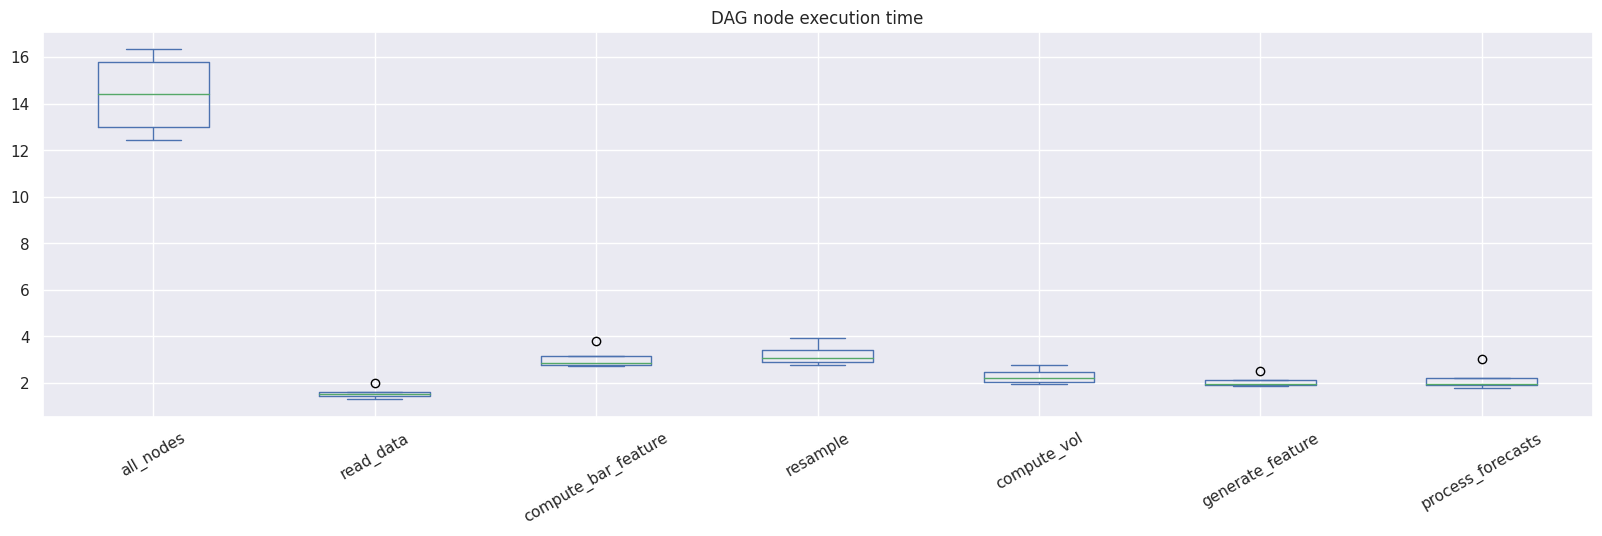

In [20]:
oms.plot_dag_execution_stats(df_dag_execution_time, report_stats=True)

In [21]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = oms.get_orders_execution_time(orders_path_dict["prod"])
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=241 secs


# Compute DAG memory consumption

In [22]:
# Use a results df's size to measure memory consumption.
dag_df_out_size = oms.get_dag_df_out_size_for_all_nodes(dag_path_dict["prod"])
_LOG.info("DAG results df size:")
hpandas.df_to_str(dag_df_out_size, num_rows=5, log_level=logging.INFO)

INFO  DAG results df size:


read_data        compute_bar_feature        resample        compute_vol        generate_feature        process_forecasts       
                             n_cols n_rows              n_cols n_rows   n_cols n_rows      n_cols n_rows           n_cols n_rows            n_cols n_rows
bar_timestamp                                                                                                                                            
2023-08-02 11:45:00-04:00       250     15                 275     15      200      3         275      3              300      3               300      3
2023-08-02 11:50:00-04:00       250     15                 275     15      200      3         275      3              300      3               300      3
2023-08-02 11:55:00-04:00       250     15                 275     15      200      3         275      3              300      3               300      3
2023-08-02 12:00:00-04:00       250     15                 275     15      200      3         275      3              300      3               300      3

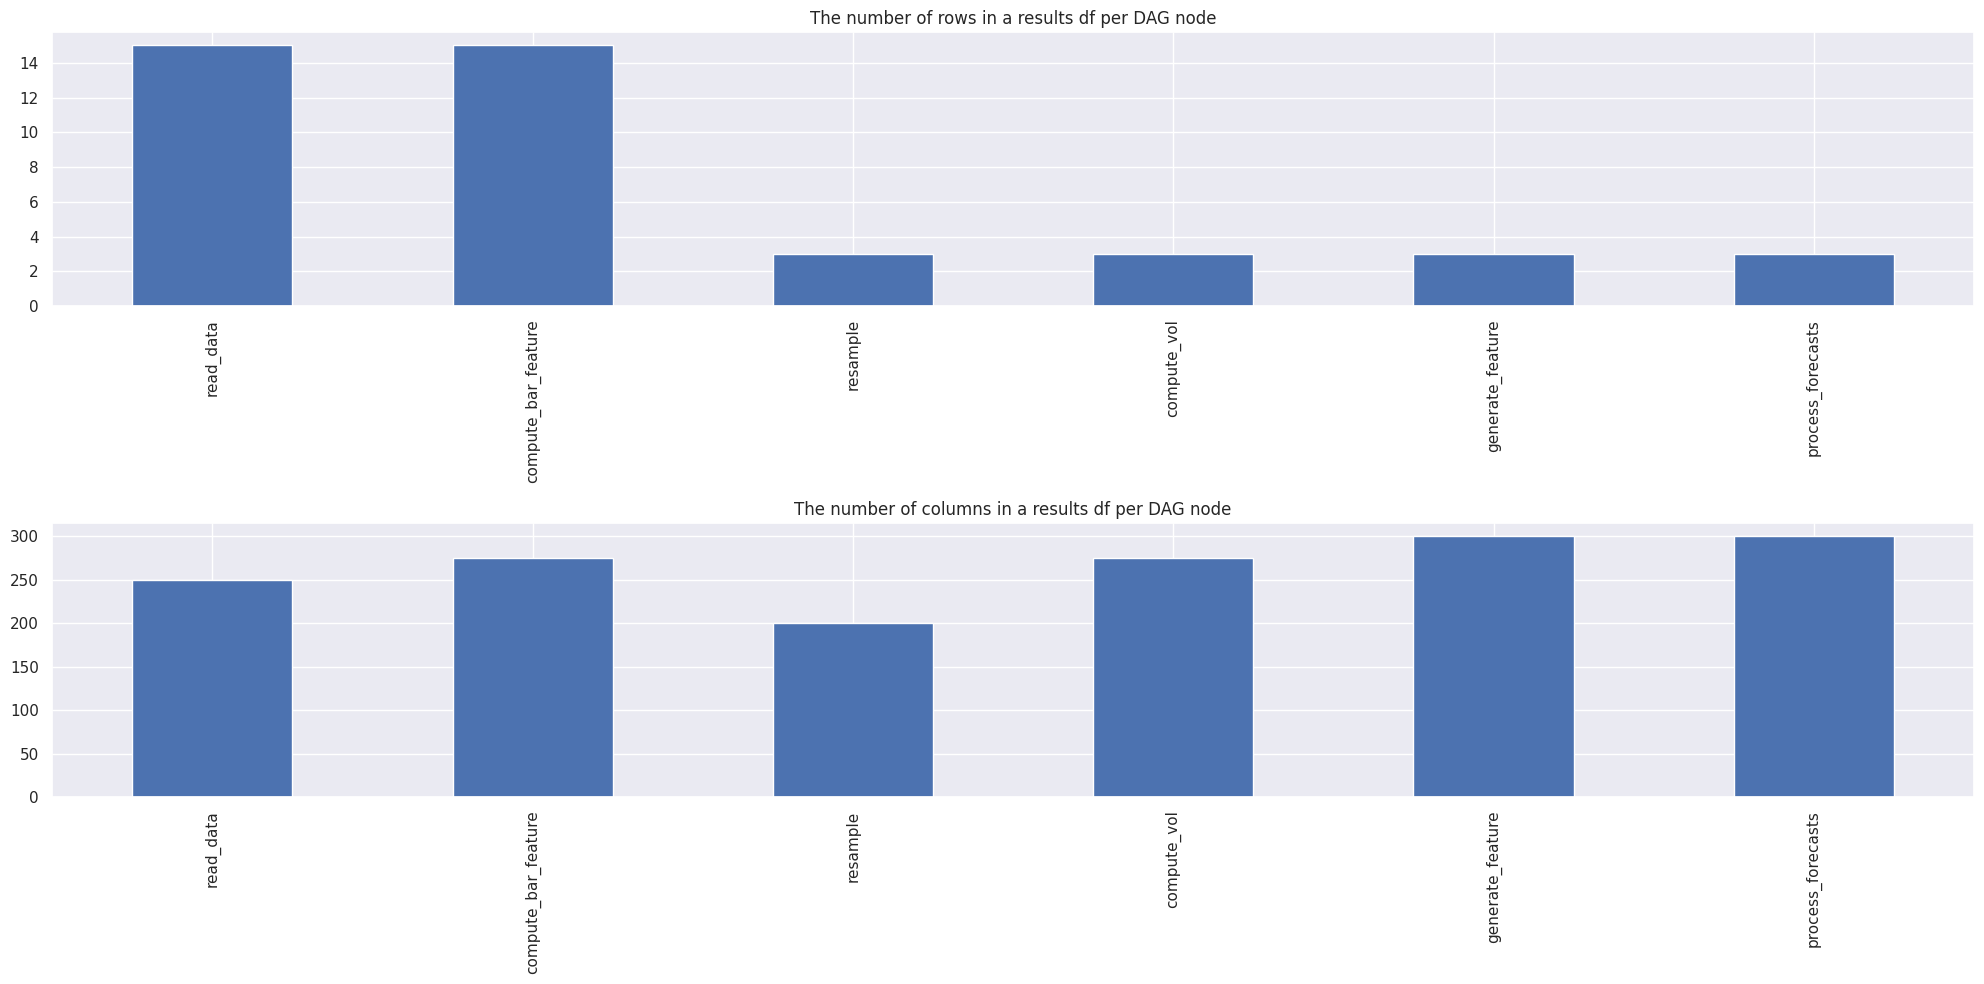

In [23]:
# Display the results df size distribution over the DAG nodes.
oms.plot_dag_df_out_size_stats(dag_df_out_size, report_stats=False)

# Portfolio

## Compute research portfolio equivalent

In [24]:
# Set Portofolio start and end timestamps.
if True:
    # By default use the min/max bar timestamps from the DAG.
    start_timestamp = dag_node_timestamps[0][0]
    end_timestamp = dag_node_timestamps[-1][0]
else:
    # Overwrite if needed.
    start_timestamp = pd.Timestamp(
        "2022-11-03 06:05:00-04:00", tz="America/New_York"
    )
    end_timestamp = pd.Timestamp(
        "2022-11-03 08:00:00-04:00", tz="America/New_York"
    )
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-08-02 11:45:00-04:00
INFO  end_timestamp=2023-08-02 12:00:00-04:00


In [25]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["research_forecast_evaluator_from_prices"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
].to_dict()
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    dag_df_prod,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod and sim portfolios.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
end_timestamp,,,,,,,,
2023-08-02 12:00:00-04:00,0.437224,4645.291354,-525.295017,2999.800381,410.503021,24.0,0.0,2.0


## Load logged portfolios (prod & sim)

In [26]:
portfolio_dfs, portfolio_stats_dfs = oms.load_portfolio_dfs(
    portfolio_path_dict,
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/4 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C3a/prod/20230802_154500.20230802_160000/simulation/system_log_dir/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/4 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                         holdings_notional                                                                                                                                                                                                                                                                          executed_trades_shares                                                                                                                                                                                                                                                                         executed_trades_notional                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                                        
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 3065029174 1891737434 1464553467 1966583502 1030828978 4516629366 2237530510 2425308589 1776791608 2601760471 3401245610 2384892553 2484635488 2683705052 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-08-02 11:45:00-04:00             0.0        0.0        0.0        0.0       0.00      0.000        0.0        0.0        0.0        0.0        0.0      0.000        0.0        0.0       0.00        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0           0.00000    0.000000    0.00000     0.0000    0.00000    0.00000    0.00000        0.0     0.0000   0.000000    0.00000        0.0    0.00000     0.0000   0.000000    0.00000   0.000000      0.000    0.00000        0.0        0.0     0.0000     0.0000    0.00000        0.0                    0.0        0.0        0.0        0.0       0.00      0.000        0.0        0.0        0.0        0.0        0.0      0.000        0.0        0.0       0.00        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    

In [27]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                           sim                                                                                      research                                                                  
                                pnl gross_volume net_volume          gmv          nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv         nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv         nmv   gpc  npc  wnl
2023-08-02 11:45:00-04:00       NaN      0.00000    0.00000     0.000000     0.000000   700.00000  700.000000  0.000000       NaN     0.000000    0.000000     0.000000    0.000000  700.000000  700.000000  0.000000       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2023-08-02 11:50:00-04:00  0.300988    808.19617  808.19617   808.497158   808.497158  -108.19617  700.300988  1.154500  0.000000  2991.330740  471.125220  2991.330740  471.125220  228.874780  700.000000  4.273330       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2023-08-02 11:55:00-04:00 -0.074718    500.93154  500.93154  1309.266980  1309.266980  -609.12771  700.139270  1.870009 -0.049140  4406.026884  463.313884  3012.098736  934.389964 -234.439104  699.950860  4.303300       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2023-08-02 12:00:00-04:00  0.337724    625.56088  625.56088  1935.240624  1935.240624 -1234.68859  700.552034  2.762451  0.821368  4632.236968 -531.511256  2986.841734  403.690286  297.072152  700.762438  4.262274  0.437224  4645.291354 -525.295017  2999.800381  410.503021  24.0  0.0  2.0

## Compute Portfolio statistics (prod vs research vs sim)

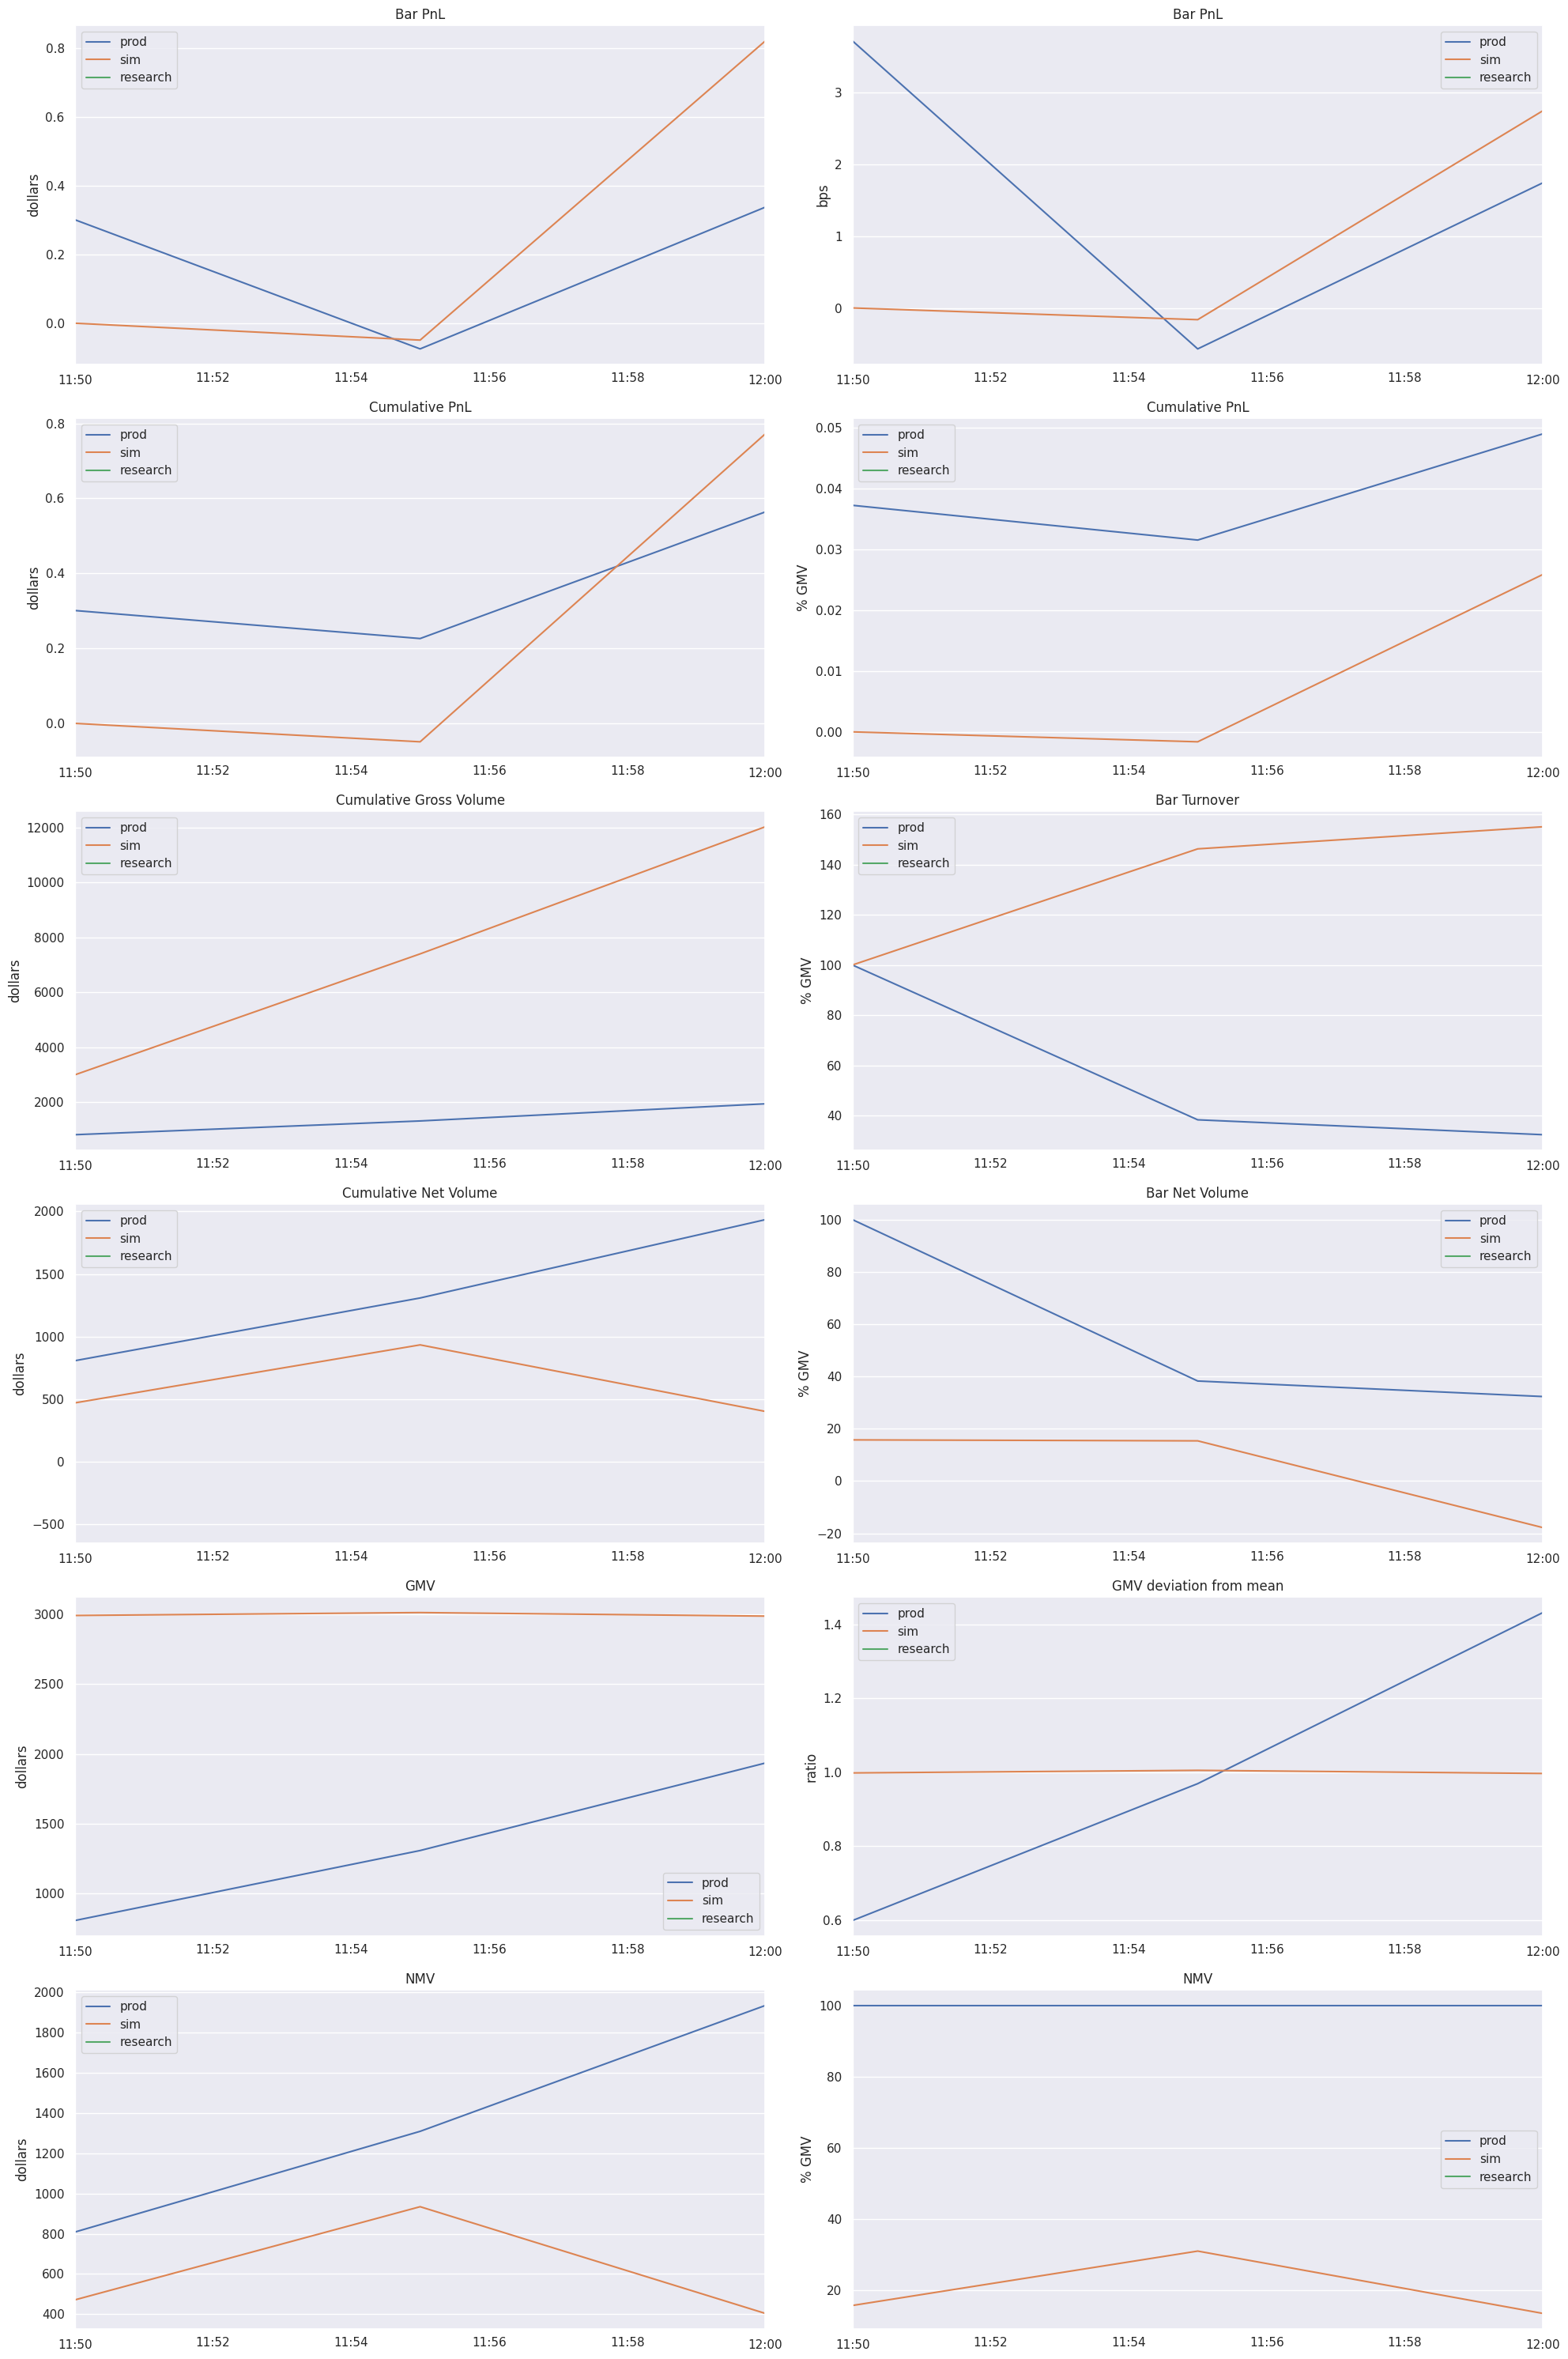

In [28]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [29]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

/venv/lib/python3.8/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


prod       sim  research
ratios     sharpe_ratio                   267.08    170.69    187.22
           sharpe_ratio_standard_error    265.35    244.67    247.67
           sr.tval                          1.43      0.91       NaN
           sr.pval                          0.29      0.46       NaN
           kratio                         119.39    166.08    187.22
dollar     gmv_mean                      1351.00   2996.76   2999.80
           gmv_stdev                      564.53     13.47       NaN
           annualized_mean_return       19769.14  27068.17  15325.61
           annualized_volatility           74.02    158.58     81.86
           max_drawdown                     0.07      0.05      0.00
           pnl_mean                         0.19      0.26      0.44
           pnl_std                          0.23      0.49       NaN
           turnover_mean                  644.90   4009.86   4645.29
           turnover_stdev                 154.54    889.30       NaN
           market_bias_mean              1351.00    603.07    410.50
           market_bias_stdev              564.53    288.91       NaN
percentage annualized_mean_return        1463.30    903.25    510.89
           annualized_volatility            5.48      5.29      2.73
           max_drawdown                     0.01      0.00      0.00
           pnl_mean                         0.01      0.01      0.01
           pnl_std                          0.02      0.02       NaN
           turnover_mean                   47.73    133.81    154.85
           turnover_stdev                  11.44     29.68       NaN
           market_bias_mean               100.00     20.12     13.68
           market_bias_stdev               41.79      9.64       NaN

## Compare portfolios pairwise (prod vs research vs sim)

### Differences

#### Prod vs sim

In [30]:
report_stats = False
display_plot = False
compare_dfs_kwargs = {
    "column_mode": "inner",
    "diff_mode": "pct_change",
    "remove_inf": True,
    "assert_diff_threshold": None,
}
portfolio_diff_df = oms.compare_portfolios(
    portfolio_dfs,
    report_stats=report_stats,
    display_plot=display_plot,
    **compare_dfs_kwargs,
)
hpandas.df_to_str(portfolio_diff_df, num_rows=None, log_level=logging.INFO)

,prod_research_diff,prod_sim_diff,research_sim_diff
executed_trades_notional.pct_change,265.472144,265.472649,0.746004
executed_trades_shares.pct_change,265.517241,265.517241,0.740741
holdings_notional.pct_change,275.000778,341.666667,20.830492
holdings_shares.pct_change,275.000000,341.666667,20.840336
pnl.pct_change,4187.740545,385.365854,522.196325


### Correlations

#### Prod vs sim

In [31]:
if False:
    dtfmod.compute_correlations(
        portfolio_dfs["prod"],
        portfolio_dfs["sim"],
        allow_unequal_indices=False,
        allow_unequal_columns=False,
    )

#### Prod vs research

In [32]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["prod"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

#### Sim vs research

In [33]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["sim"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

# Target positions

## Load target positions (prod)

In [34]:
prod_target_position_df = oms.load_target_positions(
    portfolio_path_dict["prod"].strip("portfolio"),
    config["meta"]["bar_duration"],
)
hpandas.df_to_str(prod_target_position_df, num_rows=5, log_level=logging.INFO)
if False:
    # TODO(Grisha): compare prod vs sim at some point.
    sim_target_position_df = oms.load_target_positions(
        portfolio_path_dict["sim"].strip("portfolio"),
        config["meta"]["bar_duration"],
    )

Loading `target_positions` files...:   0%|          | 0/4 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                              price                                                                                                                                                                                                                                                                         holdings_notional                                                                                                                                                                                                                                                                          prediction                                                                                                                                                                                                                                                                         volatility                                                                                                                                                                                                                                                                             spread                                                                                                                                                                                                                                                                         target_holdings_notional                                                                                                                                                                                                                                                                             target_trades_notional                                                                                                                                                                                                                                                                             target_trades_shares                                                                                                                                                                                                                                                                         target_holdings_shares                                                                                                                                                                                                                                                                         target_trades_shares.before_apply_cc_limits                                                                                                                                                                                                                                                                        
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 103082897

## Compare positions target vs executed (prod)

In [35]:
# TODO(Grisha): use `hpandas.compare_dfs()`.
df1 = prod_target_position_df["target_holdings_shares"].shift(1)
df2 = prod_target_position_df["holdings_shares"]
diff = df1 - df2
hpandas.df_to_str(diff, num_rows=5, log_level=logging.INFO)

asset_id,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
wall_clock_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-02 11:45:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-02 11:50:00-04:00,301.0,0.099,0.002,233.0,-20.9,40.1,102.0,-286.0,-6.0,0.0,188.0,-1.6,-219.0,6.0,-7.12,-175.0,-2304.0,8.9,-329.0,326.0,-216.6,12.0,-18.0,0.93,-52.0
2023-08-02 11:55:00-04:00,458.0,-0.216,0.005,270.0,-10.4,-46.2,44.0,900.0,2.0,45.0,-975.0,0.0,-98.0,-23.0,-6.20,60.0,-173.0,-24.8,59.0,-233.0,-114.1,-82.0,-14.0,-0.08,51.0
2023-08-02 12:00:00-04:00,161.0,0.068,-0.022,-1577.0,-33.5,2.6,-446.0,-316.0,2.0,-40.4,252.0,-5.4,93.0,-29.0,-9.53,70.0,-49.0,4.9,-312.0,90.0,210.7,-58.0,-28.0,0.62,-10.0


## Compare target positions (prod vs research)

### Price

In [36]:
# TODO(Grisha): wrap in a function since it's common for all columns.
column = "price"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    # Some pipelines (e.g., "C8b") do not use "close" prices to compute
    # "twap" / "vwap". While when computing target positions "close"
    # prices from MarketData are used. Thus the perfect match is not
    # expected.
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

0.18074075141094081


### Volatility

In [37]:
column = "volatility"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

1.928783522778993e-11


### Prediction

In [38]:
column = "prediction"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

5.633541258391841e-12


### Current holdings

In [39]:
column = "holdings_shares"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

274.99999999999994


### Target holdings

In [40]:
prod_df = prod_target_position_df["target_holdings_shares"].shift(1)
res_df = research_portfolio_df["holdings_shares"]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

0.2358490566037736


# Orders

## Load orders (prod & sim)

In [41]:
prod_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["prod"].strip("portfolio"),
)
hpandas.df_to_str(prod_order_df, num_rows=5, log_level=logging.INFO)
sim_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["sim"].strip("portfolio"),
)
hpandas.df_to_str(sim_order_df, num_rows=5, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/4 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2023-08-02 11:45:29.505889-04:00,6051632686,price@custom_twap,2023-08-02 11:45:29.505889-04:00,2023-08-02 11:50:00-04:00,0.0,42.0,America/New_York,{}
1,2023-08-02 11:45:29.505889-04:00,8717633868,price@custom_twap,2023-08-02 11:45:29.505889-04:00,2023-08-02 11:50:00-04:00,0.0,-14.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
358,2023-08-02 12:00:36.001746-04:00,8717633868,price@custom_twap,2023-08-02 12:00:36.001746-04:00,2023-08-02 12:05:00-04:00,4.0,-15.0,America/New_York,{}
359,2023-08-02 12:00:36.001746-04:00,8968126878,price@custom_twap,2023-08-02 12:00:36.001746-04:00,2023-08-02 12:05:00-04:00,0.94,-1.42,America/New_York,{}


Loading `orders` files...:   0%|          | 0/4 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2023-08-02 11:45:11-04:00,6051632686,price@twap,2023-08-02 11:45:11-04:00,2023-08-02 11:50:00-04:00,0.0,42.0,America/New_York,{}
1,2023-08-02 11:45:11-04:00,8717633868,price@twap,2023-08-02 11:45:11-04:00,2023-08-02 11:50:00-04:00,0.0,-14.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
90,2023-08-02 12:00:11-04:00,8968126878,price@twap,2023-08-02 12:00:11-04:00,2023-08-02 12:05:00-04:00,1.56,-2.04,America/New_York,{}
91,2023-08-02 12:00:11-04:00,9872743573,price@twap,2023-08-02 12:00:11-04:00,2023-08-02 12:05:00-04:00,-10.0,8.0,America/New_York,{}


## Compare orders (prod vs sim)

In [42]:
# TODO(Grisha): add comparison using the usual `pct_change` approach.

# Fills statistics

In [43]:
fills = oms.compute_fill_stats(prod_target_position_df)
hpandas.df_to_str(fills, num_rows=5, log_level=logging.INFO)

realized_trades_shares                                                                                                                                                                                                                                                                          fill_rate                                                                                                                                                                                                                                                                         underfill_share_count                                                                                                                                                                                                                                                                         tracking_error_shares                                                                                                                                                                                                                                                                         tracking_error_notional                                                                                                                                                                                                                                                                            tracking_error_bps                                                                                                                                                                                                                                                                                                                                
asset_id                              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573            1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573            1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573              1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052  3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573         1030828978    1464553467    1467591036    1528092593    1776791608    1891737434    1966583502 2099673105    2237530510    2384892553    2425308589 2476706208    2484635488    2540896331    2601760471    2683705052    3065029174    3401245610    4516629366 5115052901 5118394986    6051632686    8717633868   8968126878 9872743573
wall_clock_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                          

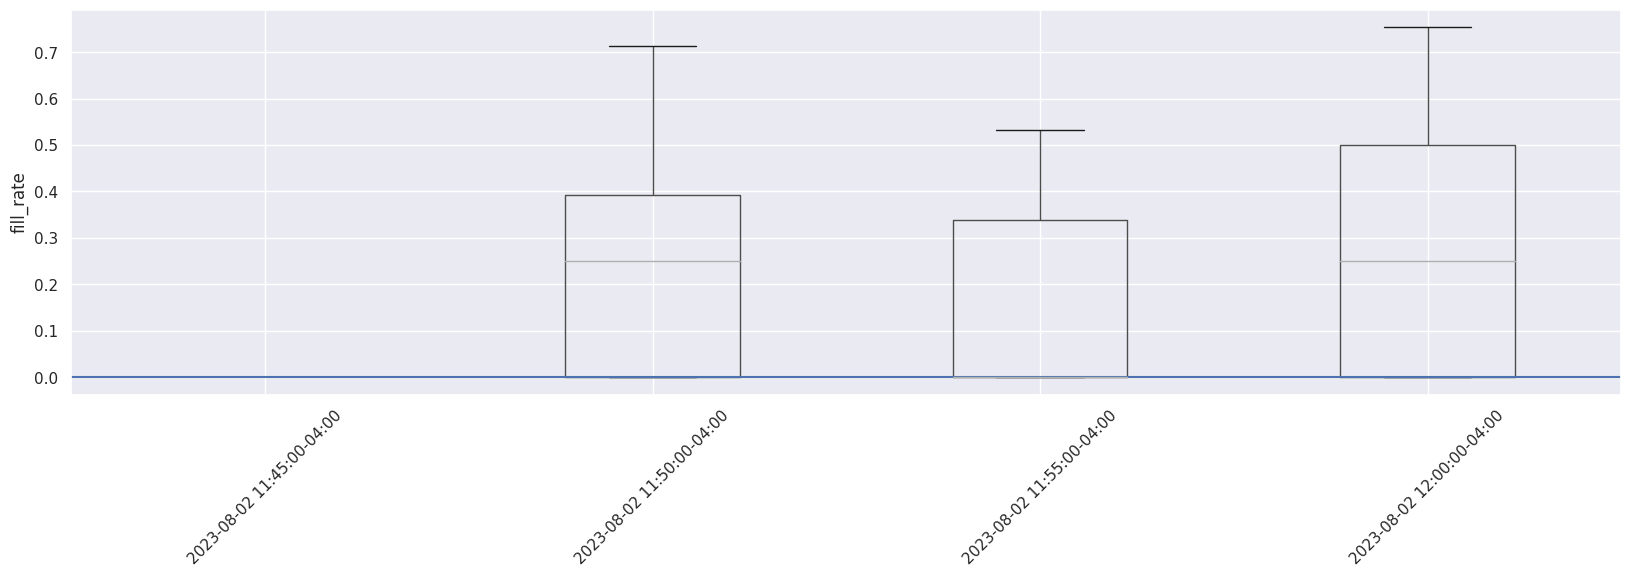

In [44]:
col = "fill_rate"
coplotti.plot_boxplot(
    fills[col], "by_row", ylabel=col
)

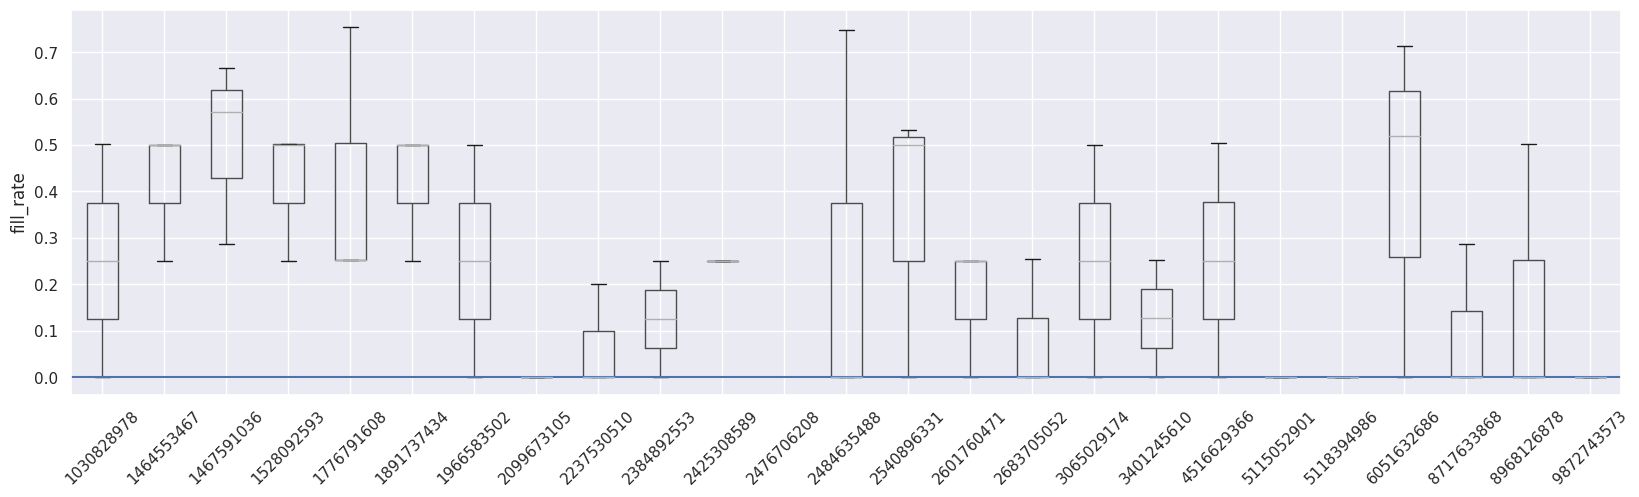

In [45]:
col = "fill_rate"
coplotti.plot_boxplot(
    fills[col], "by_col", ylabel=col
)

# Slippage

In [46]:
slippage = oms.compute_share_prices_and_slippage(portfolio_dfs["prod"])
hpandas.df_to_str(slippage, num_rows=5, log_level=logging.INFO)

holdings_price_per_share                                                                                                                                                                                                                                                                         trade_price_per_share                                                                                                                                                                                                                                                                         slippage_notional                                                                                                                                                                                                                                                                         slippage_notional_per_share                                                                                                                                                                                                                                                                         slippage_in_bps                                                                                                                                                                                                                                                                         benchmark_return_notional                                                                                                                                                                                                                                                                         benchmark_return_in_bps                                                                                                                                                                                                                                                                         is_benchmark_profitable                                                                                                                                                                                                                                                                        
                                        1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573            1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573        1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051

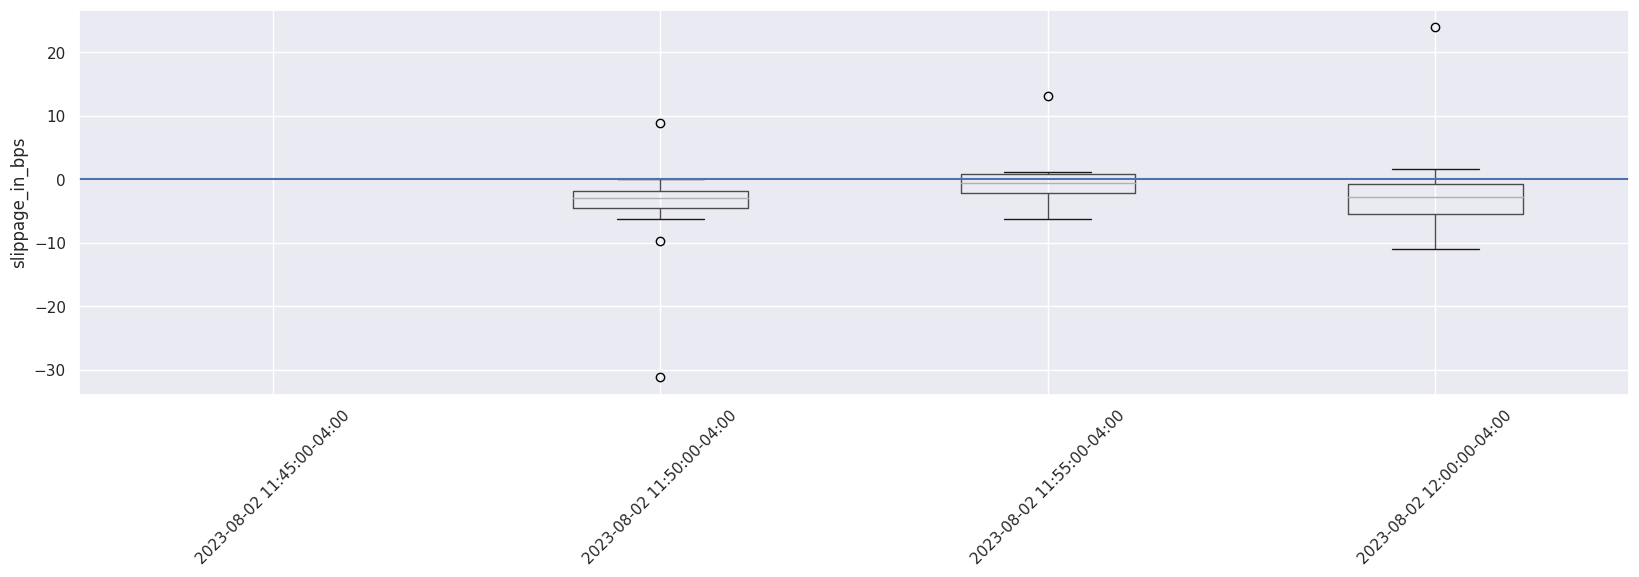

In [47]:
col = "slippage_in_bps"
coplotti.plot_boxplot(
    slippage[col], "by_row", ylabel=col
)

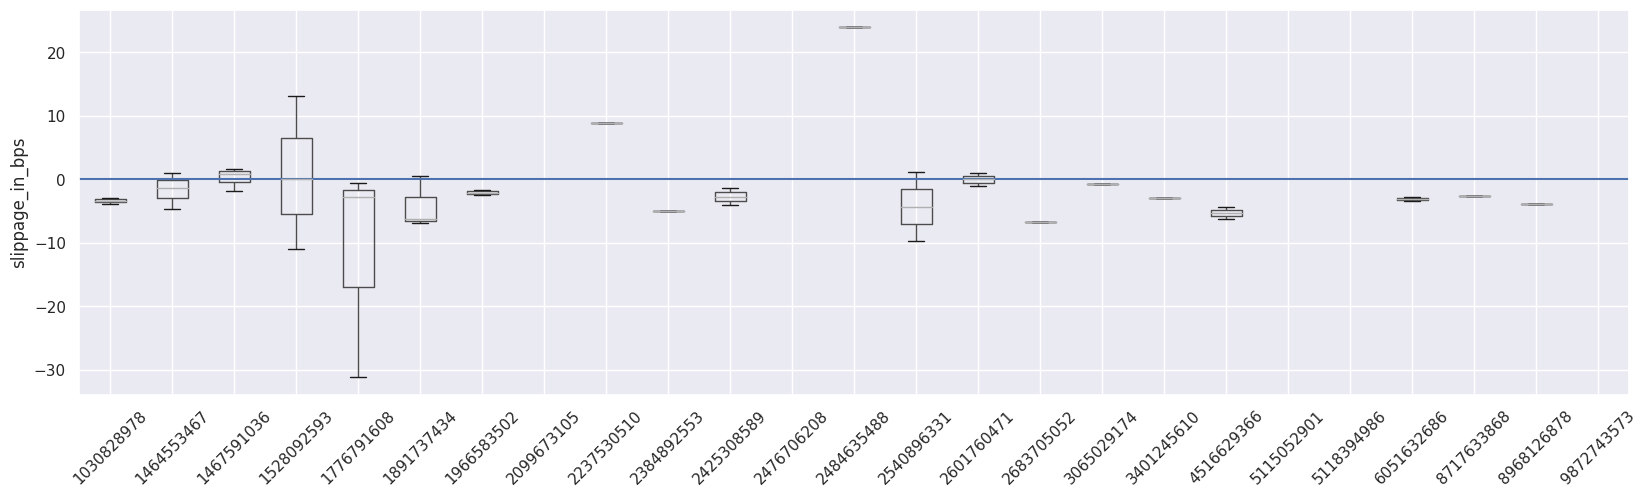

In [48]:
col = "slippage_in_bps"
coplotti.plot_boxplot(
    slippage[col], "by_col", ylabel=col
)

<Axes: >

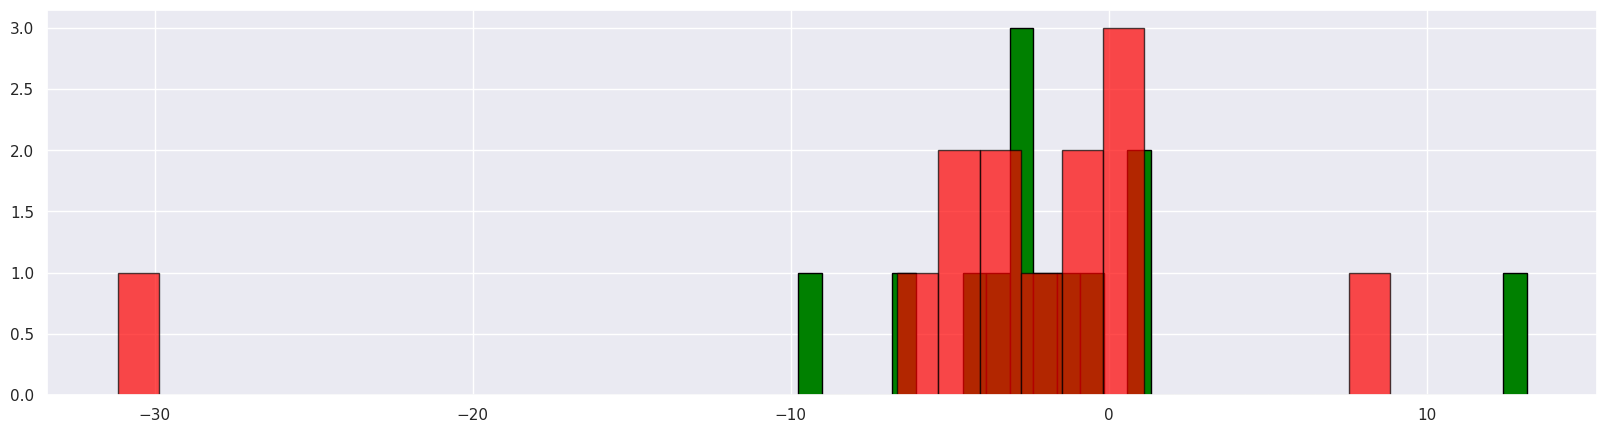

In [49]:
stacked = slippage[["slippage_in_bps", "is_benchmark_profitable"]].stack()
slippage_when_benchmark_profitable = stacked[stacked["is_benchmark_profitable"] > 0]["slippage_in_bps"].rename("slippage_when_benchmark_profitable")
slippage_when_not_benchmark_profitable = stacked[stacked["is_benchmark_profitable"] <= 0]["slippage_in_bps"].rename("slippage_when_not_benchmark_profitable")
slippage_when_benchmark_profitable.hist(
    bins=31, edgecolor="black", color="green"
)
slippage_when_not_benchmark_profitable.hist(
    bins=31, alpha=0.7, edgecolor="black", color="red"
)

<Axes: >

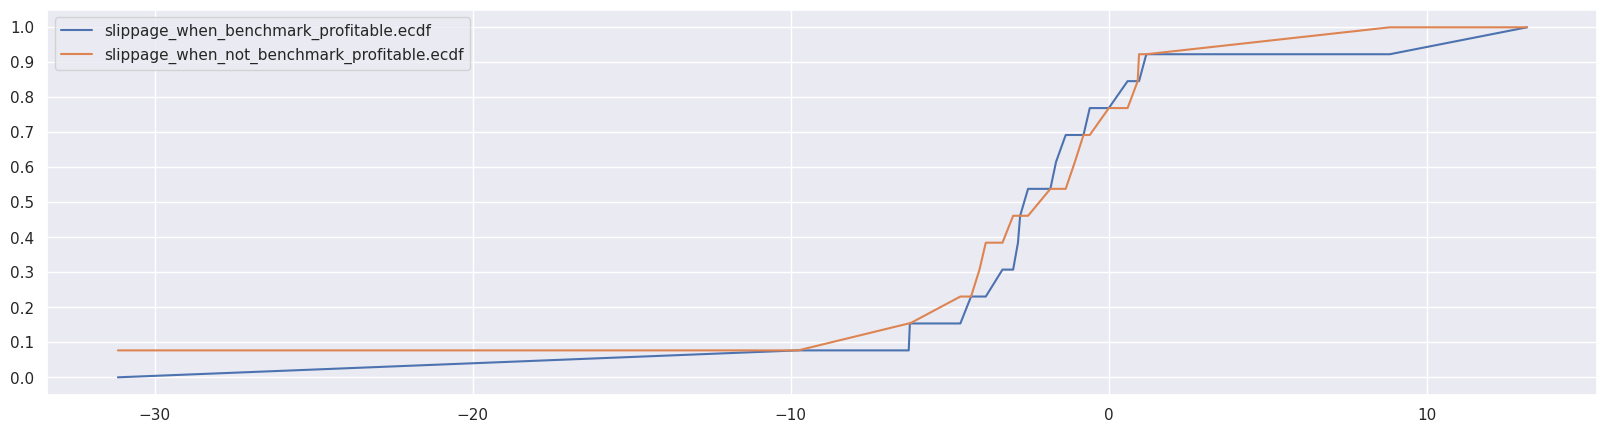

In [50]:
slippage_benchmark_profitability_ecdfs = costatis.compute_and_combine_empirical_cdfs(
    [slippage_when_benchmark_profitable, slippage_when_not_benchmark_profitable]
)
slippage_benchmark_profitability_ecdfs.plot(yticks=np.arange(0, 1.1, 0.1))

# Total cost accounting

In [51]:
notional_costs = oms.compute_notional_costs(
    portfolio_dfs["prod"],
    prod_target_position_df,
)
hpandas.df_to_str(notional_costs, num_rows=5, log_level=logging.INFO)

underfill_notional_cost                                                                                                                                                                                                                                                                         slippage_notional                                                                                                                                                                                                                                                                        
asset_id                               1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573        1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-08-02 11:45:00-04:00                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN               NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-08-02 11:50:00-04:00                     NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN          -0.00600  -0.028380   -0.02156    0.00000   -0.04368   -0.04288   -0.00408        NaN     0.0206        NaN   -0.00756        NaN        NaN    -0.0348        NaN        NaN  -0.004608        NaN   -0.01188        NaN        NaN    -0.0150    -0.0128   -0.08836        NaN
2023-08-02 11:55:00-04:00                 0.01204  -0.062370    -0.0206   -0.05126    0.00250   -0.08020    0.01632    -0.1716     0.2008     0.0000   -0.01504        0.0    0.01752      0.006  -0.027056     0.0945   0.030720    0.03916   -0.01576    0.15648   0.121296     0.0168    -0.0280   -0.03720    -0.2392               NaN   0.012600    0.00532    0.03264   -0.00042    0.00462        NaN        NaN        NaN        NaN   -0.00780        NaN        NaN     0.0056  -0.000992        NaN        NaN     -0.003   -0.01560        NaN        NaN    -0.0168        NaN        NaN        NaN
2023-08-02 12:00:00-04:00                 0.08244   0.003456    -0.0164    0.00540   -0.01488   -0.05852    0.00264     0.5400    -0.0216     0.0711   -0.08190        0.0    0.03920     -0.007   0.009672     0.0240  -0.006574    0.01480    0.02006   -0.27028  -0.041076    -0.0104    -0.0952   -0.00896     0.4386          -0.01296  -0.016116    0.03832   -0.05260   -0.01296   -0.00910   -0.00534        NaN        NaN  -0.007776   -0.00672        NaN    0.07176        NaN   0.001528   -0.01104        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN

<Axes: >

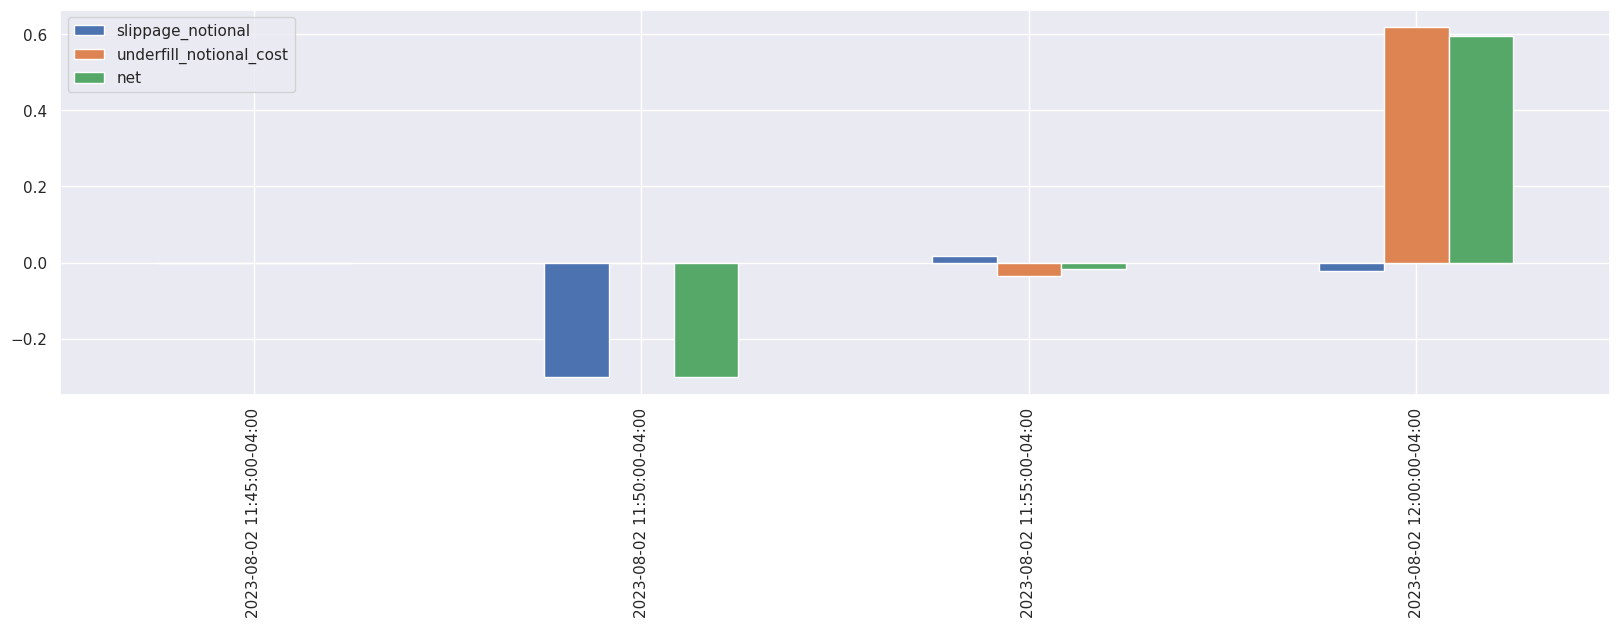

In [52]:
oms.summarize_notional_costs(notional_costs, "by_bar").plot(kind="bar")

<Axes: xlabel='asset_id'>

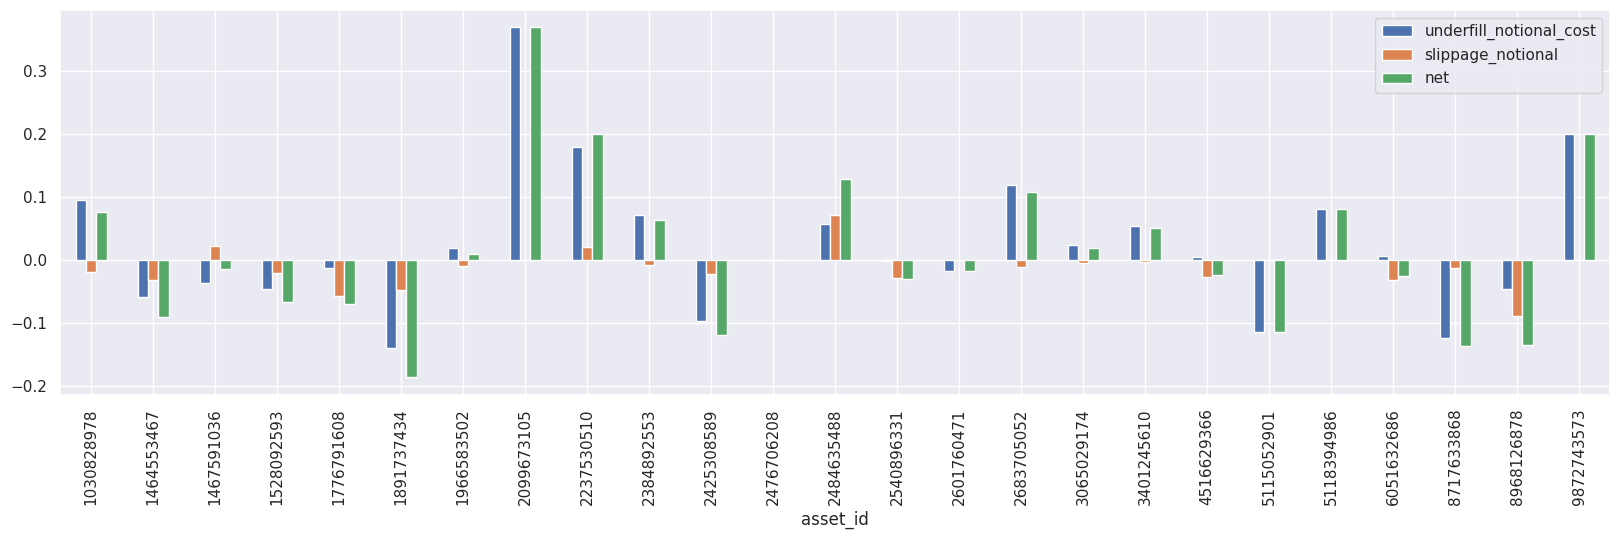

In [53]:
oms.summarize_notional_costs(notional_costs, "by_asset").plot(kind="bar")

In [54]:
oms.summarize_notional_costs(notional_costs, "by_bar").sum()

slippage_notional         -0.307824
underfill_notional_cost    0.584428
net                        0.276604
dtype: float64

In [55]:
cost_df = oms.apply_costs_to_baseline(
    portfolio_stats_dfs["research"],
    portfolio_stats_dfs["prod"],
    portfolio_dfs["prod"],
    prod_target_position_df,
)
hpandas.df_to_str(cost_df, num_rows=5, log_level=logging.INFO)

,baseline_pnl,pnl,slippage_notional,underfill_notional_cost,baseline_pnl_minus_costs,baseline_pnl_minus_costs_minus_pnl,baseline_pnl_minus_pnl
2023-08-02 11:45:00-04:00,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2023-08-02 11:50:00-04:00,NaN,0.300988,-0.300988,0.000000,NaN,NaN,NaN
2023-08-02 11:55:00-04:00,NaN,-0.074718,0.016168,-0.034150,NaN,NaN,NaN
2023-08-02 12:00:00-04:00,0.437224,0.337724,-0.023004,0.618578,-0.15835,-0.496074,0.0995


<Axes: >

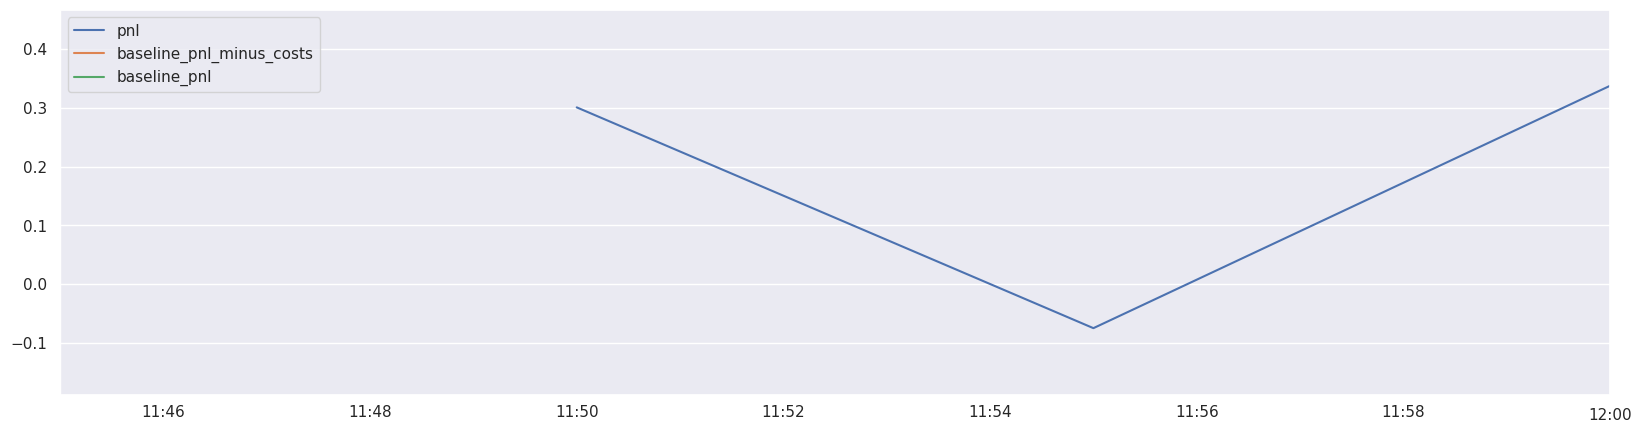

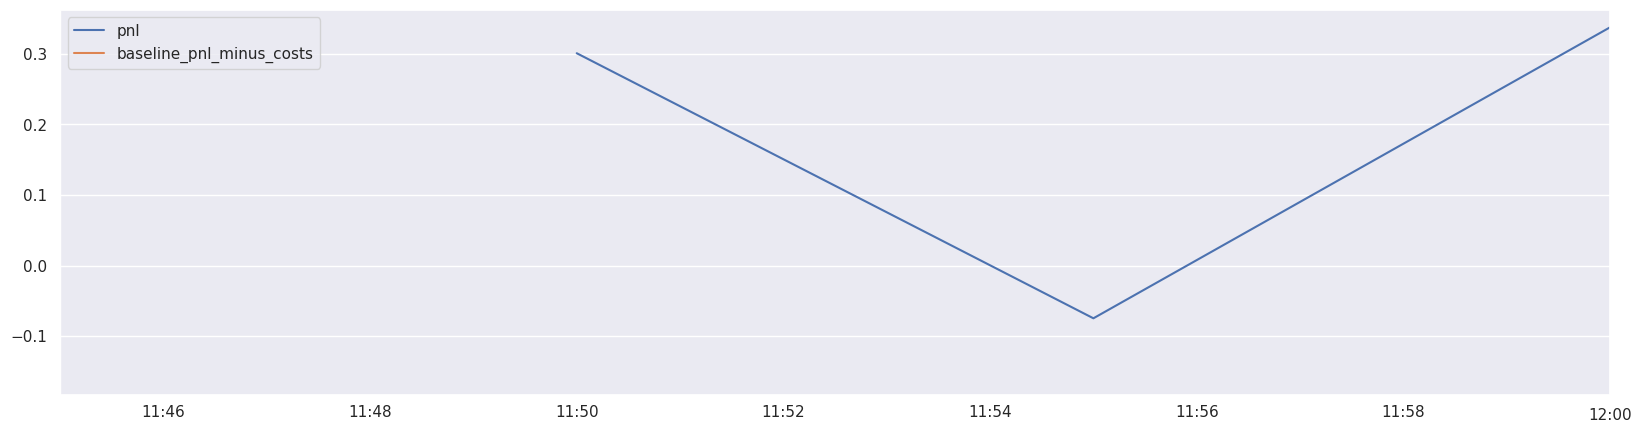

In [56]:
cost_df[["pnl", "baseline_pnl_minus_costs", "baseline_pnl"]].plot()
cost_df[["pnl", "baseline_pnl_minus_costs"]].plot()

# TCA

In [57]:
if config["meta"]["run_tca"]:
    tca = cofinanc.load_and_normalize_tca_csv(tca_csv)
    tca = cofinanc.compute_tca_price_annotations(tca, True)
    tca = cofinanc.pivot_and_accumulate_holdings(tca, "")